## Libreta para el calculo de la variación poroelástica estimada a partir de la precipitación
### Basado en la metodología de:

Feng et al. (2021): doi: https:///doi.org/10.1029/20221BJ022650; Liu et al. (2020): https://doi.org/10.1029/2020JB019524; 
Andajani et al. (2020); Wang et al. (2017) y Rivet et al.(2015)


##### $P(h,t) = \displaystyle\sum_{i=1}^{n}  \delta p_i erfc(\frac{h}{(4c(n-i)\delta t)^{1/2}})$

donde h es es la profundidad de infiltración, c es la difusividad hidráulica, dpi es es la variación de presión inducida por la precipitación

In [1]:
#Libs
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math
import datetime as dt

#### LECTURA DE DATOS

In [2]:
df = pd.read_excel('DatosMeteo-EstNevadoDeColima-Limpios+NoGaps.xlsx',usecols = [0,10])
df['Fecha de la observación'] = pd.to_datetime(df['Fecha de la observación']).dt.date
df

,Fecha de la observación,Acumulado precipitación (mm)
0,2012-12-18,0.0
1,2012-12-19,0.0
2,2012-12-20,0.0
3,2012-12-21,0.0
4,2012-12-22,0.0
...,...,...
2949,2021-01-14,0.0
2950,2021-01-15,0.0
2951,2021-01-16,0.0
2952,2021-01-17,0.0


In [3]:
def talwani_model(h, c, sampling, rain):
    mean_rain = rain.mean()
    water_change = ((rain - mean_rain)**2)**0.5
    water_change_pa = (water_change/1000) * 9.81 * 997
    
    def calc_erfc(h, c, sampling, x):
        y = math.erfc(h/math.sqrt(c*4*sampling*x))
        return y
    
    indexes_dict = range(1,len(rain)+100)
    dict_erfc = {}
    for value in indexes_dict:
        dict_erfc[value] = calc_erfc(h=h,c=c,sampling=sampling,x=value)
    dict_erfc[0] = 0
    
    model = []
    
    for ind,value in enumerate(water_change_pa):
        i = ind
        n = -i-1
        result = 0
        counter = 0
        while counter > n:
            partial = water_change_pa[i+counter] * dict_erfc[-counter]  
            result += partial
            counter -= 1
        model.append(result)
    #return model

    def pore_pressure_change(series):
        pp_change = []
        for ind,value in enumerate(series):
            if ind < len(model)-1:
                pp_change.append(series[ind+1] - series[ind])
            else:
                break
        return pp_change
    
    talwani_sol = pore_pressure_change(model)
    return(talwani_sol)

In [8]:
#Difusividad (m^2/s)
c = 1

#dt, intervalo de muestreo (s)
sampling = 86400
#86400
#Profundidad (m)
h = 1000

In [9]:
pressures = talwani_model(h=h, c=c, sampling=sampling,rain= df['Acumulado precipitación (mm)'])

Text(0, 0.5, 'Cambios de presión (Pa)')

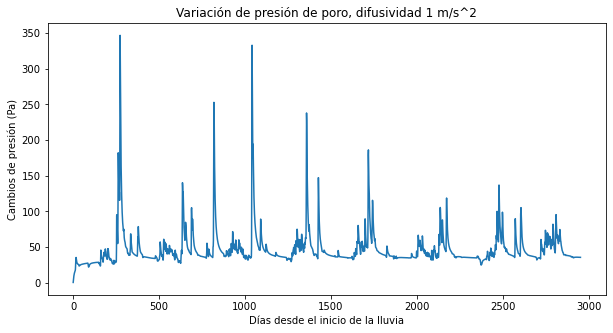

In [10]:
plt.figure(figsize=(10,5))
plt.title(f'Variación de presión de poro, difusividad {c} m/s^2')
plt.plot(pressures)
plt.xlabel('Días desde el inicio de la lluvia')
plt.ylabel('Cambios de presión (Pa)')

In [ ]:
####Metodología desglosada

#### CALCULO DEL DPI (Siguiendo la definición del cambio del nivel del agua  como la desviación de la precipitación del 2014 al 2017 respecto al promedio del 2013)

In [51]:
begintime=dt.date(2012,12,18)
endtime=dt.date(2021,1,18)

df2 = df.copy()

df2= df2.drop(df[df['Fecha de la observación'] > endtime].index)
df2 = df2.drop(df2[df2['Fecha de la observación']< begintime].index)

mean_rain = df['Acumulado precipitación (mm)'].mean()
print(f'El promedio de lluvias de {begintime} a {endtime} es: {mean_rain}')

El promedio de lluvias de 2012-12-18 a 2021-01-18 es: 3.5092332430602657


In [52]:
df3= df.copy()

df3 = df3.rename(columns={'Acumulado precipitación (mm)': 'Cambio del nivel del agua (mm)'})
#Desviacion entre la medida observada diariamente y el promedio de precipitaciones
df3['Cambio del nivel del agua (mm)'] = ((df3['Cambio del nivel del agua (mm)'] - mean_rain)**2)**0.5
#Conversión de mm a Pa
df3['Cambio del nivel del agua (Pa)'] = (df3['Cambio del nivel del agua (mm)']/1000) * 9.81 * 997 
df3

,Fecha de la observación,Cambio del nivel del agua (mm),Cambio del nivel del agua (Pa)
0,2012-12-18,3.509233,34.322301
1,2012-12-19,3.509233,34.322301
2,2012-12-20,3.509233,34.322301
3,2012-12-21,3.509233,34.322301
4,2012-12-22,3.509233,34.322301
...,...,...,...
2949,2021-01-14,3.509233,34.322301
2950,2021-01-15,3.509233,34.322301
2951,2021-01-16,3.509233,34.322301
2952,2021-01-17,3.509233,34.322301


In [58]:
def calc_erfc(h, c, sampling, x):
    y = math.erfc(h/math.sqrt(c*4*sampling*x))
    return y

#def talwani_model(h, c, sampling, rain):
    indexes_dict = range(1,3000)
    dict_erfc = {}
    for value in indexes_dict:
        dict_erfc[value] = calc_erfc(h=h,c=c,sampling=sampling,x=value)
    dict_erfc[0] = 0
    
    model = []
    #n = -365
    
    for ind,value in enumerate(dpi):
        i = ind
        n = -i-1
        result = 0
        counter = 0
        while counter > n:
            partial = dpi[i+counter] * dict_erfc[-counter]  
            result += partial
            counter -= 1
        model.append(result)
    return model

def pore_pressure_change(model):
    pp_change = []
    for ind,value in enumerate(model):
        if ind < len(model)-1:
            pp_change.append(model[ind+1] - model[ind])
        else:
            break
    return pp_change

In [59]:
#Cambio de las cargas de agua
dpi=df3['Cambio del nivel del agua (Pa)']

#Difusividad (m^2/s)
c = 0.5

#dt, intervalo de muestreo (s)
sampling = 86400
#86400
#Profundidad (m)
h = 1000

In [60]:
pressures = talwani_model(h=h, c=c, dpi=dpi,sampling=sampling)

In [61]:
pp_change = pore_pressure_change(pressures)

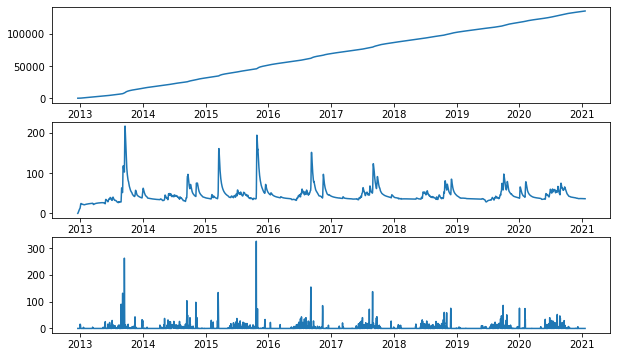

In [62]:
plt.figure(figsize=(10,6))
plt.subplot(311)
plt.plot(df3['Fecha de la observación'],pressures)

plt.subplot(312)
plt.plot(df3['Fecha de la observación'][1:],pp_change)

plt.subplot(313)
plt.plot(df3['Fecha de la observación'],df['Acumulado precipitación (mm)'])